In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from netCDF4 import Dataset
from datetime import datetime, timedelta
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
from global_land_mask import globe
import os
from netCDF4 import Dataset
from datetime import datetime, timedelta
from itertools import product
from scipy.interpolate import interp1d
from sklearn.neighbors import KDTree
from IPython.display import clear_output
import gc

def clear_memory():
    gc.collect()

# Constants for wind and solar calculations
SOLAR_PANEL_AREA = 3000  # m^2
SOLAR_PANEL_EFFICIENCY = 0.1726
RHO_AIR = 1.225  # kg/m^3, air density at sea level
KITE_AREA = 500  # m^2
LIFT_COEFFICIENT = 1.0
DRAG_COEFFICIENT = 0.1
BASE_SHIP_SPEED = 10.29  # m/s (default speed, but will be variable)
SECONDS_IN_HOUR = 3600  # seconds
SOLAR_PANEL_AREA = 3000  # m^2
SOLAR_PANEL_EFFICIENCY = 0.1726
RHO_AIR = 1.225  # kg/m^3, air density at sea level
KITE_AREA = 500  # m^2
LIFT_COEFFICIENT = 1.0
DRAG_COEFFICIENT = 0.1
BASE_SHIP_SPEED = 10.29  # m/s (default speed, but will be variable)
SECONDS_IN_HOUR = 3600  # seconds
max_steps_per_episode = 3945
# Grid size in degrees (approximately 1 hour travel distance at ship speed)
GRID_SIZE_DEGREES = BASE_SHIP_SPEED * SECONDS_IN_HOUR / 444000  # 1 degree ~ 111 km

# Directories for wind and solar data
WIND_DATA_DIR = "mera"
SOLAR_DATA_DIR = "solar energy"

# Propeller Constants
PROPELLER_DIAMETER = 6.706  # meters
THRUST_DEDUCTION_FACTOR = 0.187
WAKE_FACTOR = 0.324
RELATIVE_ROTATIVE_EFFICIENCY = 0.99
TRANSMISSION_EFFICIENCY = 0.97

# Directories for wind and solar data
WIND_DATA_DIR = "mera"
SOLAR_DATA_DIR = "solar energy"

# Action tuples representing (delta_y, delta_x) movements
action_tuples = [(-4, 0), (4, 0), (0, -4), (0, 4), (4, 4), (4, -4), (-4, 4), (-4, -4)]
actions = {i: action for i, action in enumerate(action_tuples)}
seasons = {
    'winter': [12, 1, 2],
    'spring': [3, 4, 5],
    'summer': [6, 7, 8],
    'autumn': [9, 10, 11]
}
goal_reward = 1000000
wall_penalty = -200000000
energy_consumption_penalty = -100
# Load MERRA-2 wind data from a NetCDF file
def load_wind_data(date):
    filename = f"MERRA2_400.tavg1_2d_flx_Nx.{date.strftime('%Y%m%d')}.nc4.nc4"
    filepath = os.path.join(WIND_DATA_DIR, filename)
    with Dataset(filepath) as dataset:
        uwind = dataset.variables['ULML'][:]
        vwind = dataset.variables['VLML'][:]
    return uwind, vwind

# Load MERRA-2 solar data from a NetCDF file
def load_solar_data(date):
    filename = f"MERRA2_400.tavg1_2d_rad_Nx.{date.strftime('%Y%m%d')}.nc4_2.nc4"
    filepath = os.path.join(SOLAR_DATA_DIR, filename)
    with Dataset(filepath) as dataset:
        swgnt = dataset.variables['SWGNT'][:]
    return swgnt

def calculate_ship_direction(action):
    delta_y, delta_x = action
    return np.arctan2(delta_y, delta_x)

def calculate_propeller_efficiency(propeller_diameter, thrust, thrust_deduction_factor, wake_factor):
    water_density = 1025  # kg/m^3 (typical for seawater)
    propeller_speed = BASE_SHIP_SPEED * (1 - wake_factor)  # Effective speed at the propeller

    propeller_area = np.pi * (propeller_diameter / 2)**2
    velocity_through_propeller = np.sqrt(np.abs(thrust) / (0.5 * water_density * propeller_area))

    ideal_propeller_efficiency = (1 - thrust_deduction_factor) / (1 - wake_factor)

    # Prevent division by zero
    if np.any(velocity_through_propeller == 0):
        actual_propeller_efficiency = np.zeros_like(velocity_through_propeller)
    else:
        actual_propeller_efficiency = ideal_propeller_efficiency * propeller_speed / velocity_through_propeller

    # Ensure the efficiency is within physical bounds (0 to 1)
    actual_propeller_efficiency = np.clip(actual_propeller_efficiency, 0, 1)

    return actual_propeller_efficiency

def calculate_apparent_wind(lat, lon, wind_u_data, wind_v_data, ship_speed, ship_direction, ncdf_lat, ncdf_lon):
    # Find the closest latitude and longitude index in the NetCDF data
    lat_diff = np.abs(ncdf_lat - lat)
    lon_diff = np.abs(ncdf_lon - lon)
    closest_lat_idx = np.argmin(lat_diff)
    closest_lon_idx = np.argmin(lon_diff)

    # Extract the corresponding wind data at the closest latitude and longitude
    uwind = wind_u_data[closest_lat_idx, closest_lon_idx]
    vwind = wind_v_data[closest_lat_idx, closest_lon_idx]

    wind_speed = np.sqrt(uwind**2 + vwind**2)
    wind_direction = np.arctan2(vwind, uwind)
    apparent_wind_speed = np.sqrt((wind_speed * np.cos(wind_direction - ship_direction) - ship_speed)**2 + (wind_speed * np.sin(wind_direction - ship_direction))**2)
    apparent_wind_direction = np.arctan2(wind_speed * np.sin(wind_direction - ship_direction), wind_speed * np.cos(wind_direction - ship_direction) - ship_speed)
    
    return apparent_wind_speed, apparent_wind_direction

def calculate_kite_thrust(apparent_wind_speed, apparent_wind_direction, ship_direction, kite_area, lift_coefficient, drag_coefficient):
    # Check if wind speed is above threshold
    valid_wind_speed = apparent_wind_speed >= 3.79
    
    # Calculate the angle difference
    angle_diff = np.abs(apparent_wind_direction - ship_direction)
    valid_wind_direction = (angle_diff <= 80) | (angle_diff >= 280)
    
    # If the wind speed or direction is not valid, return zero thrust
    if not (valid_wind_speed & valid_wind_direction).any():
        return np.zeros_like(apparent_wind_speed)

    # Calculate thrust only for valid wind conditions
    dynamic_pressure = 0.5 * 1.225 * np.square(apparent_wind_speed)  # air density = 1.225 kg/m^3
    lift_force = lift_coefficient * kite_area * dynamic_pressure
    drag_force = drag_coefficient * kite_area * dynamic_pressure

    # Calculate the thrust vector component aligned with the ship's direction
    effective_thrust = lift_force - drag_force
    
    # Adjust thrust based on the effectiveness of the wind direction
    thrust_multiplier = np.cos(np.deg2rad(angle_diff))
    effective_thrust *= thrust_multiplier
    
    # Apply valid wind speed and direction mask
    effective_thrust = np.where(valid_wind_speed & valid_wind_direction, effective_thrust, 0)
    
    return effective_thrust

def calculate_kite_power(lat, lon, wind_u_data, wind_v_data, ship_speed, ship_direction, kite_area, lift_coefficient, drag_coefficient, propeller_diameter, thrust_deduction_factor, wake_factor, high_res_lat, high_res_lon):
    # Calculate apparent wind using the modified function
    apparent_wind_speed, apparent_wind_direction = calculate_apparent_wind(lat, lon, wind_u_data, wind_v_data, ship_speed, ship_direction, high_res_lat, high_res_lon)
    
    # Calculate thrust using the updated function
    effective_thrust = calculate_kite_thrust(apparent_wind_speed, apparent_wind_direction, ship_direction, kite_area, lift_coefficient, drag_coefficient)
    
    # Calculate the propeller efficiency given the kite's contribution
    propeller_efficiency = calculate_propeller_efficiency(propeller_diameter, effective_thrust, thrust_deduction_factor, wake_factor)
    
    # The power generated by the kite in terms of its impact on the propeller
    kite_power = effective_thrust * propeller_efficiency
    
    return kite_power

def calculate_solar_power_output(lat, lon, solar_data, solar_panel_area, solar_panel_efficiency, ncdf_lat, ncdf_lon):
    # Find the closest latitude and longitude index in the NetCDF data
    lat_diff = np.abs(ncdf_lat - lat)
    lon_diff = np.abs(ncdf_lon - lon)
    closest_lat_idx = np.argmin(lat_diff)
    closest_lon_idx = np.argmin(lon_diff)

    # Extract the corresponding solar data at the closest latitude and longitude
    solar_flux = solar_data[closest_lat_idx, closest_lon_idx]

    # Calculate the solar power output
    return solar_panel_area * solar_panel_efficiency * solar_flux

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

class Maze:
    def __init__(self, maze, start_position, goal_position, height, width, lat, lon):
        self.maze = maze
        self.maze_height = height
        self.maze_width = width
        self.start_position = start_position
        self.goal_position = goal_position
        self.lat = lat
        self.lon = lon

    def show_maze(self):
        plt.figure(figsize=(5, 5))
        plt.imshow(self.maze, cmap='gray')
        plt.text(self.start_position[0], self.start_position[1], 'S', ha='center', va='center', color='red', fontsize=20)
        plt.text(self.goal_position[0], self.goal_position[1], 'G', ha='center', va='center', color='green', fontsize=20)
        plt.xticks([]), plt.yticks([])
        plt.show()
        np.save("maze.npy", self.maze)

class QLearningAgent:
    def __init__(self, maze, learning_rate=0.1, discount_factor=0.99, exploration_start=1.0, exploration_end=0.01, num_episodes=100):
        self.q_table = np.zeros((maze.maze_height, maze.maze_width, len(action_tuples)))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_start = exploration_start
        self.exploration_end = exploration_end
        self.num_episodes = num_episodes

    def get_exploration_rate(self, current_episode):
        return self.exploration_start * (self.exploration_end / self.exploration_start) ** (current_episode / (self.num_episodes / 2))

    def get_action(self, state, current_episode):
        exploration_rate = self.get_exploration_rate(current_episode)
        if np.random.rand() < exploration_rate:
            return np.random.randint(len(action_tuples))
        else:
            return np.argmax(self.q_table[state[1], state[0]])

    def update_q_table(self, state, action, next_state, reward):
        best_next_action = np.argmax(self.q_table[next_state[1], next_state[0]])
        current_q_value = self.q_table[state[1], state[0], action]
        new_q_value = current_q_value + self.learning_rate * (reward + self.discount_factor * self.q_table[next_state[1], next_state[0], best_next_action] - current_q_value)
        self.q_table[state[1], state[0], action] = new_q_value

import numpy as np
from skimage.draw import line

def interpolate_line_fine(start, end, step_size=0.1):
    """Interpolate points between start and end using a finer granularity."""
    x1, y1 = start
    x2, y2 = end
    dist = np.hypot(x2 - x1, y2 - y1)
    num_points = int(dist / step_size) + 1
    x_vals = np.linspace(x1, x2, num_points)
    y_vals = np.linspace(y1, y2, num_points)
    points = list(zip(np.round(x_vals).astype(int), np.round(y_vals).astype(int)))
    return points

def check_line_intersection(maze, start, end):
    """Check if the line between start and end crosses any land."""
    line_points = interpolate_line_fine(start, end)
    for point in line_points:
        x, y = point
        if not (0 <= x < maze.maze_width and 0 <= y < maze.maze_height) or maze.maze[y, x] == 1:
            return False
    return True

def finish_episode_with_hourly_averages(agent, maze, current_episode, seasonal_data, season, train=True, optimize_for="energy"):
    current_state = maze.start_position
    is_done = False
    episode_reward = 0
    episode_step = 0
    path = [current_state]
    solar_fluxes = []
    kite_thrusts = []
    kite_powers = []
    ship_headings = []

    # Retrieve the NetCDF latitudes and longitudes once
    ncdf_lat = seasonal_data[season]['lat']
    ncdf_lon = seasonal_data[season]['lon']

    while not is_done and episode_step < max_steps_per_episode:
        hour_index = episode_step % 24  # Reset the hour after 24 steps/hours

        # Extract wind and solar data for the current hour (2D arrays: lat x lon)
        wind_u_data = seasonal_data[season]['uwind'][hour_index]
        wind_v_data = seasonal_data[season]['vwind'][hour_index]
        solar_data = seasonal_data[season]['solar'][hour_index]

        # Translate current_state to latitude and longitude
        current_lat = maze.lat[current_state[1]]
        current_lon = maze.lon[current_state[0]]

        action_index = agent.get_action(current_state, current_episode)
        action = actions[action_index]

        # Calculate the ship direction based on the action (in degrees)
        ship_direction = calculate_ship_direction(action)
        ship_heading_degrees = (action_index * 45) % 360  # Convert action index to heading in degrees
        ship_headings.append(ship_heading_degrees)  # Store the ship heading

        # Determine the next state based on the action
        next_state = (current_state[0] + action[0], current_state[1] + action[1])

        # Check if the path from current_state to next_state crosses any land
        if check_line_intersection(maze, current_state, next_state):
            if next_state == maze.goal_position:
                path.append(next_state)
                reward = goal_reward
                is_done = True
            else:
                path.append(next_state)
                lat1, lon1 = maze.lat[current_state[1]], maze.lon[current_state[0]]
                lat2, lon2 = maze.lat[next_state[1]], maze.lon[next_state[0]]
                lat_end, lon_end = maze.lat[maze.goal_position[1]], maze.lon[maze.goal_position[0]]
                distance_reward = -0.1 * abs(haversine_distance(lat1, lon1, lat2, lon2)) - abs(haversine_distance(lat1, lon1, lat_end, lon_end))

                # Calculate wind and solar effects based on the closest data point
                apparent_wind_speed, apparent_wind_direction = calculate_apparent_wind(current_lat, current_lon, wind_u_data, wind_v_data, BASE_SHIP_SPEED, ship_direction, ncdf_lat, ncdf_lon)
                effective_thrust = calculate_kite_thrust(apparent_wind_speed, apparent_wind_direction, ship_direction, KITE_AREA, LIFT_COEFFICIENT, DRAG_COEFFICIENT)
                solar_power_output = calculate_solar_power_output(current_lat, current_lon, solar_data, SOLAR_PANEL_AREA, SOLAR_PANEL_EFFICIENCY, ncdf_lat, ncdf_lon)

                # Calculate wind power (assuming zero if not aligned with ship direction)
                wind_power = np.where(np.abs(apparent_wind_direction - ship_direction) < np.pi / 2, effective_thrust, 0)

                # Calculate energy consumption
                energy_gain = (effective_thrust.mean() - wind_power.mean() + solar_power_output.mean()) * 0.01  # Adjust scaling as necessary
                energy_reward = energy_consumption_penalty * energy_gain

                # Combine rewards
                if optimize_for == "energy":
                    reward = distance_reward + energy_reward
                else:
                    reward = distance_reward

                # Record values for plotting later
                solar_fluxes.append(solar_power_output.mean())
                kite_thrusts.append(effective_thrust.mean())
                kite_powers.append(wind_power.mean())
        else:
            next_state = current_state  # The move is invalid, so the state doesn't change
            reward = wall_penalty  # Penalize the move

        episode_reward += reward
        episode_step += 1

        if train:
            agent.update_q_table(current_state, action_index, next_state, reward - 200 * episode_step)

        current_state = next_state

    return episode_reward, episode_step, path, solar_fluxes, kite_thrusts, kite_powers, ship_headings

def calculate_savings(best_solar_fluxes, best_kite_powers, hours_taken):
    # Constants for fuel consumption
    sfoc = 0.193  # kg/kWh (specific fuel oil consumption)
    fuel_per_day_tons = 42.5
    kwh_per_day = fuel_per_day_tons / sfoc * 1000

    # Emission factors per ton of fuel
    emission_factors = {
        'SOx': 1.7,
        'NOx': 11.8,
        'CO2': 690,
        'PM': 0.4
    }

    # Calculate total energy generated by kite and solar power
    total_kite_power_kwh = np.sum(best_kite_powers) * hours_taken / 1000
    total_solar_power_kwh = np.sum(best_solar_fluxes) * hours_taken / 1000
    total_energy_generated_kwh = total_kite_power_kwh + total_solar_power_kwh

    # Calculate the total energy consumption if only the engine was used
    total_engine_energy_consumption_kwh = kwh_per_day * (hours_taken / 24)

    # Calculate fuel saved in tons
    fuel_saved_tons = min(fuel_per_day_tons, sfoc * total_energy_generated_kwh / 1000)

    # Calculate percentage savings
    percentage_energy_saved = (total_energy_generated_kwh / total_engine_energy_consumption_kwh) * 100

    # Calculate percentage contribution from solar and wind
    if total_energy_generated_kwh > 0:
        solar_savings_percent = (total_solar_power_kwh / total_energy_generated_kwh) * 100
        wind_savings_percent = (total_kite_power_kwh / total_energy_generated_kwh) * 100
    else:
        solar_savings_percent = 0
        wind_savings_percent = 0

    # Calculate pollutants saved
    pollutants_saved = {pollutant: (total_energy_generated_kwh * factor) / 1_000_000 for pollutant, factor in emission_factors.items()}
    pollutants_saved = {key: value if fuel_saved_tons == fuel_per_day_tons else value * (fuel_saved_tons / fuel_per_day_tons) for key, value in pollutants_saved.items()}

    # Calculate total fuel consumption assuming no wind and solar
    total_fuel_consumed_without_savings_tons = sfoc * total_engine_energy_consumption_kwh / 1000

    return (fuel_saved_tons, pollutants_saved, percentage_energy_saved, 
            solar_savings_percent, wind_savings_percent, total_fuel_consumed_without_savings_tons)

def save_best_path_data(best_path, best_solar_fluxes, best_kite_thrusts, best_kite_powers, high_res_maze, high_res_lat, high_res_lon, season_dir, season):
    # High-resolution path plot
    image_path = os.path.join(season_dir, f'{season}_best_path_8k.png')

    plt.figure(figsize=(48, 27), dpi=220)
    plt.imshow(high_res_maze, cmap='gray', extent=(high_res_lon.min(), high_res_lon.max(), high_res_lat.min(), high_res_lat.max()))

    if best_path:
        path_lat_lon = [(high_res_lat[pos[1]], high_res_lon[pos[0]]) for pos in best_path]
        path_x, path_y = zip(*path_lat_lon)
        plt.plot(path_x, path_y, 'bo-', linewidth=2, markersize=5, label='Best Path')
        plt.scatter([path_x[0]], [path_y[0]], color='red', s=100, label='Start')
        plt.scatter([path_x[-1]], [path_y[-1]], color='green', s=100, label='Goal')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'{season.capitalize()} - Best Path Over High-Resolution Maze')
    plt.legend()
    plt.grid()
    plt.savefig(image_path, dpi=768)
    plt.close()

    # Save the best path's solar flux and kite power data as npy files
    np.save(os.path.join(season_dir, f'{season}_best_solar_fluxes.npy'), best_solar_fluxes)
    np.save(os.path.join(season_dir, f'{season}_best_kite_powers.npy'), best_kite_powers)
    np.save(os.path.join(season_dir, f'{season}_best_kite_thrusts.npy'), best_kite_thrusts)

    print(f"Best day of {season.capitalize()} has reward and is saved in {season_dir}")

def plot_and_save_all(season_dir, season, episode_rewards, best_solar_fluxes, best_kite_thrusts, best_kite_powers, best_ship_headings):
    plt.figure(figsize=(38.4, 21.6), dpi=220)  # 4K resolution: 3840x2160 pixels

    # Plot 1: Episode rewards
    plt.subplot(3, 2, 1)
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title(f'{season.capitalize()} - Reward per Episode')
    plt.savefig(os.path.join(season_dir, f'{season}_episode_rewards.png'), dpi=220)
    plt.close()

    # Plot 2: Solar Flux per Step
    plt.figure(figsize=(38.4, 21.6), dpi=220)
    plt.plot(best_solar_fluxes, label='Solar Flux (W/m^2)')
    plt.xlabel('Step')
    plt.ylabel('Solar Flux (W/m^2)')
    plt.title(f'{season.capitalize()} - Solar Flux per Step')
    plt.legend()
    plt.savefig(os.path.join(season_dir, f'{season}_solar_flux.png'), dpi=220)
    plt.close()

    # Plot 3: Kite Thrust per Step
    plt.figure(figsize=(38.4, 21.6), dpi=220)
    plt.plot(best_kite_thrusts, label='Kite Thrust (N)')
    plt.xlabel('Step')
    plt.ylabel('Kite Thrust (N)')
    plt.title(f'{season.capitalize()} - Kite Thrust per Step')
    plt.legend()
    plt.savefig(os.path.join(season_dir, f'{season}_kite_thrust.png'), dpi=220)
    plt.close()

    # Plot 4: Kite Power per Step
    plt.figure(figsize=(38.4, 21.6), dpi=220)
    plt.plot(best_kite_powers, label='Kite Power (W)')
    plt.xlabel('Step')
    plt.ylabel('Kite Power (W)')
    plt.title(f'{season.capitalize()} - Kite Power per Step')
    plt.legend()
    plt.savefig(os.path.join(season_dir, f'{season}_kite_power.png'), dpi=220)
    plt.close()

    # Plot 5: Ship Heading vs. Steps
    plt.figure(figsize=(38.4, 21.6), dpi=220)
    plt.plot(best_ship_headings, label='Ship Heading (degrees)')
    plt.xlabel('Step')
    plt.ylabel('Heading (degrees)')
    plt.title(f'{season.capitalize()} - Ship Heading vs. Steps')
    plt.legend()
    plt.savefig(os.path.join(season_dir, f'{season}_ship_headings.png'), dpi=220)
    plt.close()

    print(f"All plots for {season.capitalize()} have been saved.")

def plot_best_path_and_save(season_dir, season, best_path, best_solar_fluxes, best_kite_thrusts, best_kite_powers, episode_rewards, best_ship_headings, high_res_maze, high_res_lat, high_res_lon, low_res_lat, low_res_lon, maze):
    plt.figure(figsize=(38.4, 21.6), dpi=220)  # 4K resolution: 3840x2160 pixels

    # Plot 1: Episode rewards
    plt.subplot(3, 2, 1)
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title(f'{season.capitalize()} - Reward per Episode')

    # Plot 2: Steps per episode (constant for best path)
    plt.subplot(3, 2, 2)
    plt.plot([len(best_path)] * len(episode_rewards))
    plt.xlabel('Episode')
    plt.ylabel('Steps Taken')
    plt.title(f'{season.capitalize()} - Steps per Episode')

    # Plot 3: High-resolution maze with best path
    plt.subplot(3, 2, 3)
    plt.imshow(high_res_maze, cmap='gray')

    if best_path is not None:
        # Translate low-resolution path to latitude and longitude
        translated_path = []
        for point in best_path:
            lat = low_res_lat[point[1]]
            lon = low_res_lon[point[0]]
            translated_path.append((lat, lon))
        
        # Find the closest points on the high-resolution maze
        high_res_path = []
        for lat, lon in translated_path:
            lat_diff = np.abs(high_res_lat - lat)
            lon_diff = np.abs(high_res_lon - lon)
            closest_lat_idx = np.argmin(lat_diff)
            closest_lon_idx = np.argmin(lon_diff)
            high_res_path.append((closest_lon_idx, closest_lat_idx))

        high_res_path_x, high_res_path_y = zip(*high_res_path)
        
        # Plot the translated path with a thick line
        plt.plot(high_res_path_x, high_res_path_y, color='blue', linewidth=3)  # Thicker line for path

        # Plot the start and goal positions
        start_lat = low_res_lat[maze.start_position[1]]
        start_lon = low_res_lon[maze.start_position[0]]
        start_lat_diff = np.abs(high_res_lat - start_lat)
        start_lon_diff = np.abs(high_res_lon - start_lon)
        start_closest_lat_idx = np.argmin(start_lat_diff)
        start_closest_lon_idx = np.argmin(start_lon_diff)
        plt.scatter([start_closest_lon_idx], [start_closest_lat_idx], color='red', s=100, label='Start')

        goal_lat = low_res_lat[maze.goal_position[1]]
        goal_lon = low_res_lon[maze.goal_position[0]]
        goal_lat_diff = np.abs(high_res_lat - goal_lat)
        goal_lon_diff = np.abs(high_res_lon - goal_lon)
        goal_closest_lat_idx = np.argmin(goal_lat_diff)
        goal_closest_lon_idx = np.argmin(goal_lon_diff)
        plt.scatter([goal_closest_lon_idx], [goal_closest_lat_idx], color='green', s=100, label='Goal')

        plt.xticks([]), plt.yticks([])
        plt.grid(color='black', linewidth=2)
        plt.title(f'{season.capitalize()} - Final Path Learned in High Resolution')

    # Plot 4: Solar Flux per Step
    plt.subplot(3, 2, 4)
    plt.plot(best_solar_fluxes, label='Solar Flux (W/m^2)')
    plt.xlabel('Step')
    plt.ylabel('Solar Flux (W/m^2)')
    plt.title(f'{season.capitalize()} - Solar Flux per Step')
    plt.legend()

    # Plot 5: Kite Thrust per Step
    plt.subplot(3, 2, 5)
    plt.plot(best_kite_thrusts, label='Kite Thrust (N)')
    plt.xlabel('Step')
    plt.ylabel('Kite Thrust (N)')
    plt.title(f'{season.capitalize()} - Kite Thrust per Step')
    plt.legend()

    # Plot 6: Kite Power per Step
    plt.subplot(3, 2, 6)
    plt.plot(best_kite_powers, label='Kite Power (W)')
    plt.xlabel('Step')
    plt.ylabel('Kite Power (W)')
    plt.title(f'{season.capitalize()} - Kite Power per Step')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(season_dir, f'{season}_best_day_plots.png'), dpi=220)  # Save with high resolution
    plt.close()
    #plot 7: ship heading
    plt.figure(figsize=(38.4, 21.6), dpi=220)
    plt.plot(best_ship_headings, label='Ship Heading (degrees from North)')
    plt.xlabel('Step')
    plt.ylabel('Heading (degrees)')
    plt.title(f'{season.capitalize()} - Ship Heading vs. Steps')
    plt.legend()
    plt.savefig(os.path.join(season_dir, f'{season}_ship_heading.png'), dpi=220)
    plt.close()

    print(f"All plots for {season.capitalize()} have been saved.")

def save_savings(season_dir, season, fuel_saved_tons, pollutants_saved, percentage_energy_saved, 
                 solar_savings_percent, wind_savings_percent, total_fuel_consumed_without_savings_tons):
    savings_path = os.path.join(season_dir, f'{season}_savings.txt')
    with open(savings_path, 'w') as f:
        f.write(f"Total fuel consumption without savings: {total_fuel_consumed_without_savings_tons:.2f} tons\n")
        f.write(f"Fuel saved: {fuel_saved_tons:.2f} tons\n")
        f.write(f"Percentage energy saved: {percentage_energy_saved:.2f}%\n")
        f.write(f"Percentage of savings from solar power: {solar_savings_percent:.2f}%\n")
        f.write(f"Percentage of savings from wind power: {wind_savings_percent:.2f}%\n")
        for pollutant, amount in pollutants_saved.items():
            f.write(f"{pollutant} saved: {amount:.2f} tons\n")

def process_seasonal_routes(agent, maze, seasonal_data, season, num_episodes=1000):
    results_dir = "seasonal_routes"
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)

    season_dir = os.path.join(results_dir, season)
    if not os.path.exists(season_dir):
        os.makedirs(season_dir)

    high_res_lat = np.load('high_res_lat.npy')
    high_res_lon = np.load('high_res_lon.npy')
    high_res_maze = np.load('high_res_maze.npy')

    print(f"Processing {season.capitalize()}...")

    best_reward = -float('inf')
    best_path = None
    best_solar_fluxes = []
    best_kite_thrusts = []
    best_kite_powers = []
    best_ship_headings = []
    episode_rewards = []

    for episode in range(num_episodes):
        episode_reward, episode_step, path, solar_fluxes, kite_thrusts, kite_powers, ship_headings = finish_episode_with_hourly_averages(agent, maze, episode, seasonal_data, season, train=True, optimize_for="energy")
        episode_rewards.append(episode_reward)
        print(f"Episode {episode} - Steps: {episode_step}, Reward: {episode_reward}")
        if episode % 100 == 0:
            clear_output(wait=False)

        if episode_reward > best_reward:
            best_reward = episode_reward
            best_path = path
            best_solar_fluxes = solar_fluxes
            best_kite_thrusts = kite_thrusts
            best_kite_powers = kite_powers
            best_ship_headings = ship_headings
            best_episode_step = episode_step

    # Save plots and data
    plot_best_path_and_save(season_dir, season, best_path, best_solar_fluxes, best_kite_thrusts, best_kite_powers, episode_rewards, best_ship_headings, high_res_maze, high_res_lat, high_res_lon, maze.lat, maze.lon, maze)

    # Calculate savings and save them
    (fuel_saved_tons, pollutants_saved, percentage_energy_saved, 
     solar_savings_percent, wind_savings_percent, total_fuel_consumed_without_savings_tons) = calculate_savings(best_solar_fluxes, best_kite_powers, best_episode_step)

    # Save the calculated savings
    save_savings(season_dir, season, fuel_saved_tons, pollutants_saved, percentage_energy_saved, 
                 solar_savings_percent, wind_savings_percent, total_fuel_consumed_without_savings_tons)

    print(f"Total fuel consumption without savings: {total_fuel_consumed_without_savings_tons:.2f} tons")
    print(f"Fuel saved: {fuel_saved_tons:.2f} tons")
    print(f"Percentage energy saved: {percentage_energy_saved:.2f}%")
    print(f"Percentage of savings from solar power: {solar_savings_percent:.2f}%")
    print(f"Percentage of savings from wind power: {wind_savings_percent:.2f}%")
    for pollutant, amount in pollutants_saved.items():
        print(f"{pollutant} saved: {amount:.2f} tons")

    clear_memory()

    print(f"{season.capitalize()} processing complete and results saved.")

def calculate_hourly_averages_for_season(year):
    seasonal_data = {}
    
    # Load a sample file to get lat/lon information
    sample_file = "mera\MERRA2_400.tavg1_2d_flx_Nx.20230101.nc4.nc4"  # Replace with an actual file path
    with Dataset(sample_file, 'r') as dataset:
        lat = dataset.variables['lat'][:]
        lon = dataset.variables['lon'][:]
    
    for season, months in seasons.items():
        wind_u_hourly_total = np.zeros((24,) + (len(lat), len(lon)))
        wind_v_hourly_total = np.zeros_like(wind_u_hourly_total)
        solar_hourly_total = np.zeros((24,) + (len(lat), len(lon)))
        hour_count = np.zeros(24)  # Counter for averaging

        for month in months:
            num_days = (datetime(year, month % 12 + 1, 1) - datetime(year, month, 1)).days
            for day in range(1, num_days + 1):
                date = datetime(year, month, day)
                try:
                    uwind, vwind = load_wind_data(date)
                    swgnt = load_solar_data(date)
                    
                    for hour in range(24):
                        wind_u_hourly_total[hour] += uwind[hour]
                        wind_v_hourly_total[hour] += vwind[hour]
                        solar_hourly_total[hour] += swgnt[hour]
                        hour_count[hour] += 1
                except FileNotFoundError:
                    continue

        # Calculate hourly averages
        seasonal_data[season] = {
            'uwind': wind_u_hourly_total / hour_count[:, None, None],
            'vwind': wind_v_hourly_total / hour_count[:, None, None],
            'solar': solar_hourly_total / hour_count[:, None, None],
            'lat': lat,
            'lon': lon
        }
    
    return seasonal_data




<>:659: SyntaxWarning: invalid escape sequence '\M'
<>:659: SyntaxWarning: invalid escape sequence '\M'
C:\Users\parsh\AppData\Local\Temp\ipykernel_6700\3688720065.py:659: SyntaxWarning: invalid escape sequence '\M'
  sample_file = "mera\MERRA2_400.tavg1_2d_flx_Nx.20230101.nc4.nc4"  # Replace with an actual file path


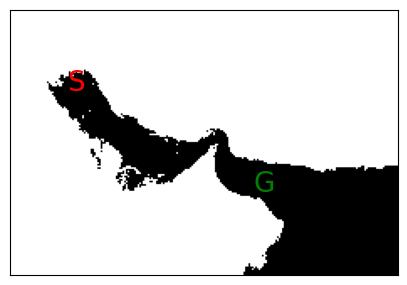

In [3]:
DEPTH_THRESHOLD = -11.4  # Threshold for considering depth as land (negative because depths are usually negative below sea level)
GRID_SIZE_DEGREES = BASE_SHIP_SPEED * SECONDS_IN_HOUR / 444000  # 1 degree ~ 111 km

# Load the depth data from the GEBCO dataset
gebco_file = "gebco_2024_n32.995_s19.859_w46.248_e64.8881.nc"
with Dataset(gebco_file, 'r') as dataset:
    gebco_lat = dataset.variables['lat'][:]
    gebco_lon = dataset.variables['lon'][:]
    gebco_elevation = dataset.variables['elevation'][:]

# Mirror the elevation data around the x-axis (latitude)
gebco_elevation = gebco_elevation[::-1]

# Create a KDTree for fast lookup of the closest depth point
depth_tree = KDTree(np.array(list(product(gebco_lat, gebco_lon))))

# Original start and destination points
origin = [49.469, 29.362]
destination = [58.836, 24.385]
if origin[0] > destination[0]:
    origin, destination = destination, origin

# Create latitude and longitude grids for the maze
lat = np.arange(19.859, 32.995, GRID_SIZE_DEGREES)
lon = np.arange(46.248, 64.881 + 0.625, GRID_SIZE_DEGREES)
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Initialize the maze using global land mask
z = globe.is_land(lat_grid, lon_grid)
z = np.array(z[::-1].astype(int))

# Find the closest depth point for each maze point and mark as land if depth > -11.4 meters
for i in range(z.shape[0]):
    for j in range(z.shape[1]):
        # Get the current lat/lon
        current_lat = lat[i]
        current_lon = lon[j]
        
        # Find the closest depth data point
        _, idx = depth_tree.query([[current_lat, current_lon]])
        closest_depth = gebco_elevation.flatten()[idx[0]]
        
        # If the depth is higher than the threshold, mark as land
        if closest_depth > DEPTH_THRESHOLD:
            z[i, j] = 1

# Determine start and goal positions
test_lat = lat - origin[1]
test_lat = test_lat[::-1]
test_lon = lon - origin[0]
start_pos_lat = np.where(abs(test_lat) == min(abs(test_lat)))
start_pos_lon = np.where(abs(test_lon) == min(abs(test_lon)))
startpos = (start_pos_lon[0][0], start_pos_lat[0][0])

test_lat = lat - destination[1]
test_lat = test_lat[::-1]
test_lon = lon - destination[0]
destination_pos_lat = np.where(abs(test_lat) == min(abs(test_lat)))
destination_pos_lon = np.where(abs(test_lon) == min(abs(test_lon)))
destinationpos = (destination_pos_lon[0][0], destination_pos_lat[0][0])
lat = lat[::-1]
lon = lon[::-1]

# Initialize the maze with the updated z array
maze = Maze(z, startpos, destinationpos, len(z), len(z[0]), lat, lon)
maze.show_maze()

In [6]:
high_res_maze_file = 'high_res_maze.npy'
new_z = np.load(high_res_maze_file)

# Initialize the route agent
route_agent = QLearningAgent(maze, num_episodes=2500)

# Calculate seasonal averages
seasonal_data = calculate_hourly_averages_for_season(2023)

# Process seasonal routes
high_res_lat = np.load('high_res_lat.npy')
high_res_lon = np.load('high_res_lon.npy')
high_res_maze = np.load('high_res_maze.npy')

# Process the routes
# Example usage for winter
process_seasonal_routes(agent=route_agent, maze=maze, seasonal_data=seasonal_data, season='summer', num_episodes=2500)


Episode 2401 - Steps: 28, Reward: -3005986.321871235
Episode 2402 - Steps: 28, Reward: -3005986.321871235
Episode 2403 - Steps: 28, Reward: -3005986.321871235
Episode 2404 - Steps: 28, Reward: -3005986.321871235
Episode 2405 - Steps: 28, Reward: -3005986.321871235
Episode 2406 - Steps: 28, Reward: -3005986.321871235
Episode 2407 - Steps: 28, Reward: -3005986.321871235
Episode 2408 - Steps: 28, Reward: -3005986.321871235
Episode 2409 - Steps: 28, Reward: -3005986.321871235
Episode 2410 - Steps: 28, Reward: -3005986.321871235
Episode 2411 - Steps: 28, Reward: -3005986.321871235
Episode 2412 - Steps: 28, Reward: -3005986.321871235
Episode 2413 - Steps: 28, Reward: -3005986.321871235
Episode 2414 - Steps: 28, Reward: -3005986.321871235
Episode 2415 - Steps: 28, Reward: -3005986.321871235
Episode 2416 - Steps: 28, Reward: -3005986.321871235
Episode 2417 - Steps: 28, Reward: -3005986.321871235
Episode 2418 - Steps: 28, Reward: -3005986.321871235
Episode 2419 - Steps: 28, Reward: -3005986.321

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from PIL import Image
import os

def animate_wind_over_region(seasonal_data, num_hours, high_res_maze_img, output_folder, grid_resolution=3, vector_density=2):
    # Extract wind data and lat/lon
    wind_u_data = seasonal_data['uwind']
    wind_v_data = seasonal_data['vwind']
    lat = seasonal_data['lat']
    lon = seasonal_data['lon']
    
    # Reduce resolution for visualization
    wind_u_reduced = wind_u_data[:, ::grid_resolution, ::grid_resolution]
    wind_v_reduced = wind_v_data[:, ::grid_resolution, ::grid_resolution]
    lat_reduced = lat[::grid_resolution]
    lon_reduced = lon[::grid_resolution]
    
    # Calculate wind speed
    wind_speed = np.sqrt(wind_u_reduced**2 + wind_v_reduced**2)
    
    # Create latitude and longitude grids
    lon_grid, lat_grid = np.meshgrid(lon_reduced, lat_reduced)
    
    # Load the high-resolution maze image
    maze_img = Image.open(high_res_maze_img)
    
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    def update(hour):
        # Create figure and axis anew for each frame
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Plot background maze image
        ax.imshow(maze_img, extent=(lon.min(), lon.max(), lat.min(), lat.max()), alpha=0.3)
        
        # Plot wind speed heatmap
        cf = ax.contourf(lon_grid, lat_grid, wind_speed[hour], cmap='viridis', alpha=0.7)
        plt.colorbar(cf, ax=ax, label='Wind Speed (m/s)')
        
        # Plot wind direction vectors
        ax.quiver(lon_grid[::vector_density, ::vector_density], lat_grid[::vector_density, ::vector_density],
                  wind_u_reduced[hour, ::vector_density, ::vector_density], wind_v_reduced[hour, ::vector_density, ::vector_density],
                  scale=100, headlength=3, headwidth=3, headaxislength=3, color='black')
        
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title(f'Wind Speed and Direction at Hour {hour}')
        
        # Save the frame as an image file
        frame_file = os.path.join(output_folder, f'frame_{hour:02d}.png')
        plt.savefig(frame_file, dpi=100)
        plt.close(fig)
    
    # Generate frames
    for hour in range(num_hours):
        update(hour)
    
    # Convert saved frames to GIF using Pillow
    frames = [Image.open(os.path.join(output_folder, f'frame_{hour:02d}.png')) for hour in range(num_hours)]
    gif_output_file = os.path.join(output_folder, 'wind_animation_over_region.gif')
    frames[0].save(gif_output_file, save_all=True, append_images=frames[1:], duration=1000, loop=0)
    
    # Cleanup frame files
    for hour in range(num_hours):
        os.remove(os.path.join(output_folder, f'frame_{hour:02d}.png'))

    print(f"Animation saved as {gif_output_file}")

# Example usage
output_folder = 'seasonal_routes/winter'
high_res_maze_img = 'high_res_maze.png'
num_hours = 24  # The number of hours (steps) you want to animate
animate_wind_over_region(seasonal_data['winter'], num_hours, high_res_maze_img, output_folder, grid_resolution=3, vector_density=1)



Animation saved as seasonal_routes/winter\wind_animation_over_region.gif


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from PIL import Image
import os

def animate_solar_flux_over_region(seasonal_data, num_hours, high_res_maze_img, output_folder, grid_resolution=3):
    # Extract solar flux data and lat/lon
    solar_data = seasonal_data['solar']
    lat = seasonal_data['lat']
    lon = seasonal_data['lon']
    
    # Reduce resolution for visualization
    solar_reduced = solar_data[:, ::grid_resolution, ::grid_resolution]
    lat_reduced = lat[::grid_resolution]
    lon_reduced = lon[::grid_resolution]
    
    # Create latitude and longitude grids
    lon_grid, lat_grid = np.meshgrid(lon_reduced, lat_reduced)
    
    # Load the high-resolution maze image
    maze_img = Image.open(high_res_maze_img)
    
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    def update(hour):
        # Create figure and axis anew for each frame
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Plot background maze image
        ax.imshow(maze_img, extent=(lon.min(), lon.max(), lat.min(), lat.max()), alpha=0.3)
        
        # Plot solar flux heatmap
        cf = ax.contourf(lon_grid, lat_grid, solar_reduced[hour], cmap='plasma', alpha=0.7)
        plt.colorbar(cf, ax=ax, label='Solar Flux (W/m^2)')
        
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title(f'Solar Flux at Hour {hour}')
        
        # Save the frame as an image file
        frame_file = os.path.join(output_folder, f'frame_{hour:02d}.png')
        plt.savefig(frame_file, dpi=100)
        plt.close(fig)
    
    # Generate frames
    for hour in range(num_hours):
        update(hour)
    
    # Convert saved frames to GIF using Pillow
    frames = [Image.open(os.path.join(output_folder, f'frame_{hour:02d}.png')) for hour in range(num_hours)]
    gif_output_file = os.path.join(output_folder, 'solar_flux_animation_over_region.gif')
    frames[0].save(gif_output_file, save_all=True, append_images=frames[1:], duration=1000, loop=0)
    
    # Cleanup frame files
    for hour in range(num_hours):
        os.remove(os.path.join(output_folder, f'frame_{hour:02d}.png'))

    print(f"Animation saved as {gif_output_file}")

# Example usage
output_folder = 'seasonal_routes/winter'
num_hours = 24  # The number of hours (steps) you want to animate
animate_solar_flux_over_region(seasonal_data['winter'], num_hours, high_res_maze_img, output_folder, grid_resolution=3)


Animation saved as seasonal_routes/winter\solar_flux_animation_over_region.gif
